### Importy a nastavení

In [ ]:
import pandas as pd
import joblib

import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
mlflow.set_experiment("Iris Classification")

2025/06/08 16:05:02 INFO mlflow.tracking.fluent: Experiment with name 'Iris Classification' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///d:/SDA/AI8028-MLFlow/mlruns/923380395482545675', creation_time=1749391502063, experiment_id='923380395482545675', last_update_time=1749391502063, lifecycle_stage='active', name='Iris Classification', tags={}>

### Načtení a příprava dat

In [6]:
# Load the Iris dataset
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

y = df['target']
X = df.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Random forest s ML logováním

In [7]:
parameters = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5],
    "min_samples_split": [2, 5],
    "max_features": ["sqrt", "log2"],
}
rf = RandomForestClassifier()
gs = GridSearchCV(rf, parameters)
gs.fit(X_train, y_train)

,estimator,RandomForestClassifier()
,param_grid,"{'max_depth': [None, 5], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 5], 'n_estimators': [50, 100, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,50


In [8]:
print(gs.best_params_)
rf = gs.best_estimator_

{'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 50}


In [9]:
y_pred = rf.predict(X_test)

In [19]:
metrics = {}

In [20]:
print(classification_report(y_test, y_pred))
metrics["accuracy"] = accuracy_score(y_test, y_pred)
metrics["recall"] = recall_score(y_test, y_pred, average="weighted")
metrics["f1"] = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



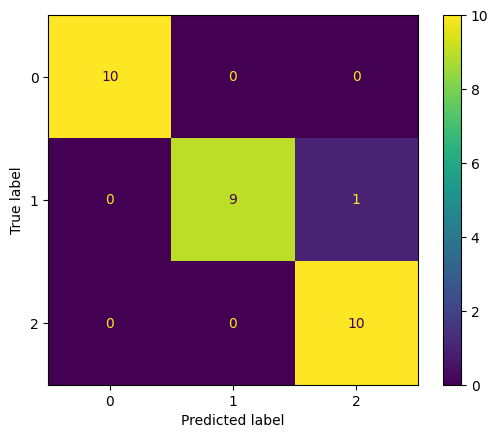

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [25]:
signature = infer_signature(X_train, rf.predict(X_train))
# Start a new run within the experiment
with mlflow.start_run():
    # Log parameters, metrics, and artifacts
    mlflow.log_params(gs.best_params_)
    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(rf, "iris_rf_model", signature=signature)

### Logování grid

In [ ]:
mlflow.set_experiment("Iris Grid Search")

In [27]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}
grid = ParameterGrid(param_grid)

for params in grid:
    with mlflow.start_run():
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)
        accuracy = model.score(X_test, y_test)

        mlflow.log_params(params)
        mlflow.log_metric("accuracy", accuracy)